In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 17 14:49:49 2019

@author: Samira
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
import os 
from sklearn.preprocessing import minmax_scale
import math

Using TensorFlow backend.


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()
    
    filename = os.path.join(model_name, "digits_over_latent.png")
    
    # display a 10x102D manifold of waves
    
    n = 10
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    fig = plt.figure(figsize=(100, 100))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            #print(x_decoded.shape)
            digit = x_decoded[0]
            #temp = np.reshape(x_decoded, (44944, 1))
            #plt.plot(temp)
            plt.subplot(n,n, i*n + j+1)
            plt.plot(np.reshape(digit/digit.mean(), (44944,1)))

    plt.show()

In [4]:
x_train = np.load("/kaggle/input/audio-binary-classification/train_data.npy")
x_test = np.load("/kaggle/input/audio-binary-classification/test_data.npy")
y_train = pd.read_csv('/kaggle/input/audio-binary-classification/train_labels.csv').loc[:,'Label'].values

"""
train_scaled = minmax_scale(x_train, axis = 0)
test_scaled = minmax_scale(x_test, axis = 0)
"""
image_size = int(math.sqrt(x_train.shape[1]))+2
desire_size = int(math.pow(212, 2))
original_size = x_train.shape[1]
pad_size = desire_size - x_train.shape[1]
x_train = np.c_[ x_train,   np.zeros((x_train.shape[0], pad_size))] 
x_test = np.c_[x_test, np.zeros((x_test.shape[0], pad_size))] 
#x_train = sc.fit_transform(x_train)
#x_test = sc.transform(x_test)
x_train = np.reshape(x_train, (-1, image_size, image_size, 1))
x_test = np.reshape(x_test, (-1, image_size, image_size, 1))


In [5]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=1,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 212, 212, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 106, 106, 32) 320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 53, 53, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 179776)       0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [6]:

models = (encoder, decoder)
#data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss
reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)

kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

plot_model(vae, to_file='vae_cnn_latent2.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 212, 212, 1)       0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 2895316   
_________________________________________________________________
decoder (Model)              (None, 212, 212, 1)       595009    
Total params: 3,490,325
Trainable params: 3,490,325
Non-trainable params: 0
_________________________________________________________________


In [7]:
# train the autoencoder
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_cnn_mnist.h5')
#plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

Train on 3999 samples, validate on 3997 samples
Epoch 1/30
3999/3999 [==============================] - 290s 73ms/step - loss: 6485.6129 - val_loss: -201.9619
Epoch 2/30
3999/3999 [==============================] - 288s 72ms/step - loss: -82.9277 - val_loss: -160.4910
Epoch 3/30
3999/3999 [==============================] - 287s 72ms/step - loss: -168.3080 - val_loss: -194.9213
Epoch 4/30
3999/3999 [==============================] - 287s 72ms/step - loss: -192.1040 - val_loss: -260.6734
Epoch 5/30
3999/3999 [==============================] - 287s 72ms/step - loss: -254.2843 - val_loss: -263.5614
Epoch 6/30
3999/3999 [==============================] - 288s 72ms/step - loss: -276.2766 - val_loss: -321.0386
Epoch 7/30
3999/3999 [==============================] - 287s 72ms/step - loss: -293.7369 - val_loss: -288.5234
Epoch 8/30
3999/3999 [==============================] - 286s 72ms/step - loss: -303.2299 - val_loss: -315.6297
Epoch 9/30
3999/3999 [==============================] - 287s 72ms

In [8]:
encoder, decoder = models

_, _, encoded_train = encoder.predict(x_train)
#pd.DataFrame() 
_, _, encoded_test = encoder.predict(x_test) 
# display a 2D plot of the digit classes in the latent space
#z_mean, z_log_var, z_test = encoder.predict(x_test,batch_size=batch_size)

In [9]:
print(encoded_train.shape)
print(encoded_test.shape)

(3999, 2)
(3997, 2)


In [10]:
# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(encoded_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict_proba(encoded_test)

In [11]:
df = pd.DataFrame(y_pred[:,1], index = range(y_pred.shape[0]))
df.reset_index(level=0, inplace=True)
df.columns=['Id', 'Label']
df.to_csv("y_pred_VAE_2_RF.csv", index=False)

In [12]:

def plot_embedded_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)

    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

In [13]:
def plot_fake_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots fake data as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """
    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    
    n = 10
    digit_size = 44944
    #figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
    fig = plt.figure(figsize=(100, 100))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            #print(x_decoded.shape)
            digit = x_decoded[0]
            #print(digit[0,0:200])
            #plt.plot(x_test[0,:])
            #print(digit.shape)
            temp = np.reshape(x_decoded, (44944, 1))
            #plt.plot(temp)
            plt.subplot(n,n, i*n + j+1)
            plt.plot(np.reshape(digit, (44944,1)))

    plt.show()


In [14]:
X = np.load("/kaggle/input/audio-binary-classification/train_data.npy")
y = pd.read_csv('/kaggle/input/audio-binary-classification/train_labels.csv').loc[:,'Label'].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
import math 
image_size = int(math.sqrt(x_train.shape[1]))+2
desire_size = int(math.pow(212, 2))
original_size = x_train.shape[1]
pad_size = desire_size - x_train.shape[1]
x_train = np.c_[ x_train,   np.zeros((x_train.shape[0], pad_size))] 
x_test = np.c_[x_test, np.zeros((x_test.shape[0], pad_size))] 
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train = np.reshape(x_train, (-1, image_size, image_size, 1))
x_test = np.reshape(x_test, (-1, image_size, image_size, 1))

In [15]:
# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 30

In [16]:
def VAE_builder(latent_dim=2, filters=16, epochs=30, batch_size=128, kernel_size=3, input_shape =(212,212,1), plot_res=True):
    # VAE model = encoder + decoder
    # build encoder model
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for i in range(2):
        filters *= 2
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   activation='relu',
                   strides=2,
                   padding='same')(x)

    # shape info needed to build decoder model
    shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for i in range(2):
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            activation='relu',
                            strides=2,
                            padding='same')(x)
        filters //= 2

    outputs = Conv2DTranspose(filters=1,
                              kernel_size=kernel_size,
                              activation='sigmoid',
                              padding='same',
                              name='decoder_output')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()
    plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)
    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  K.flatten(outputs))

    reconstruction_loss *= image_size * image_size
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)

    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')
    vae.summary()


    plot_model(vae, to_file='vae_cnn.png', show_shapes=True)
     # train the autoencoder
    vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None))
    vae.save_weights('vae_cnn.h5')
    if(plot_res):
        plot_embedded_results(models, data, batch_size=batch_size, model_name="vae_cnn")
        plot_fake_results(models, data, batch_size=batch_size, model_name="vae_cnn")
    


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 212, 212, 1)  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 106, 106, 32) 320         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 53, 53, 64)   18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 179776)       0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
dense_3 (D

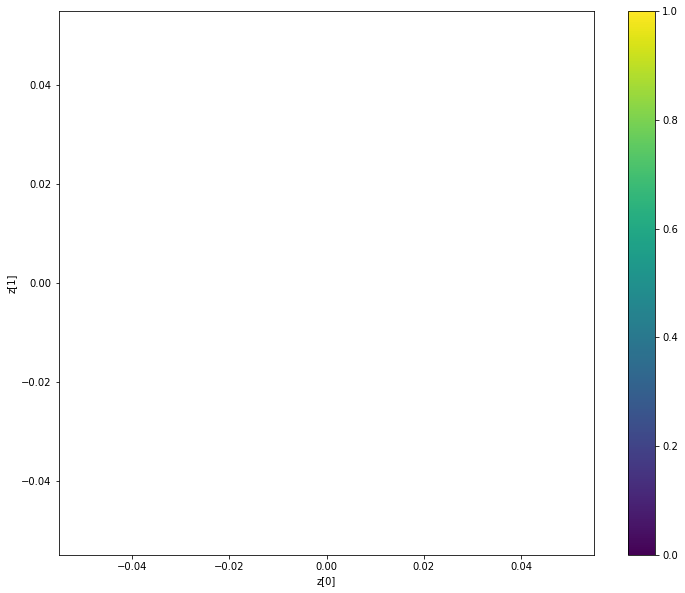

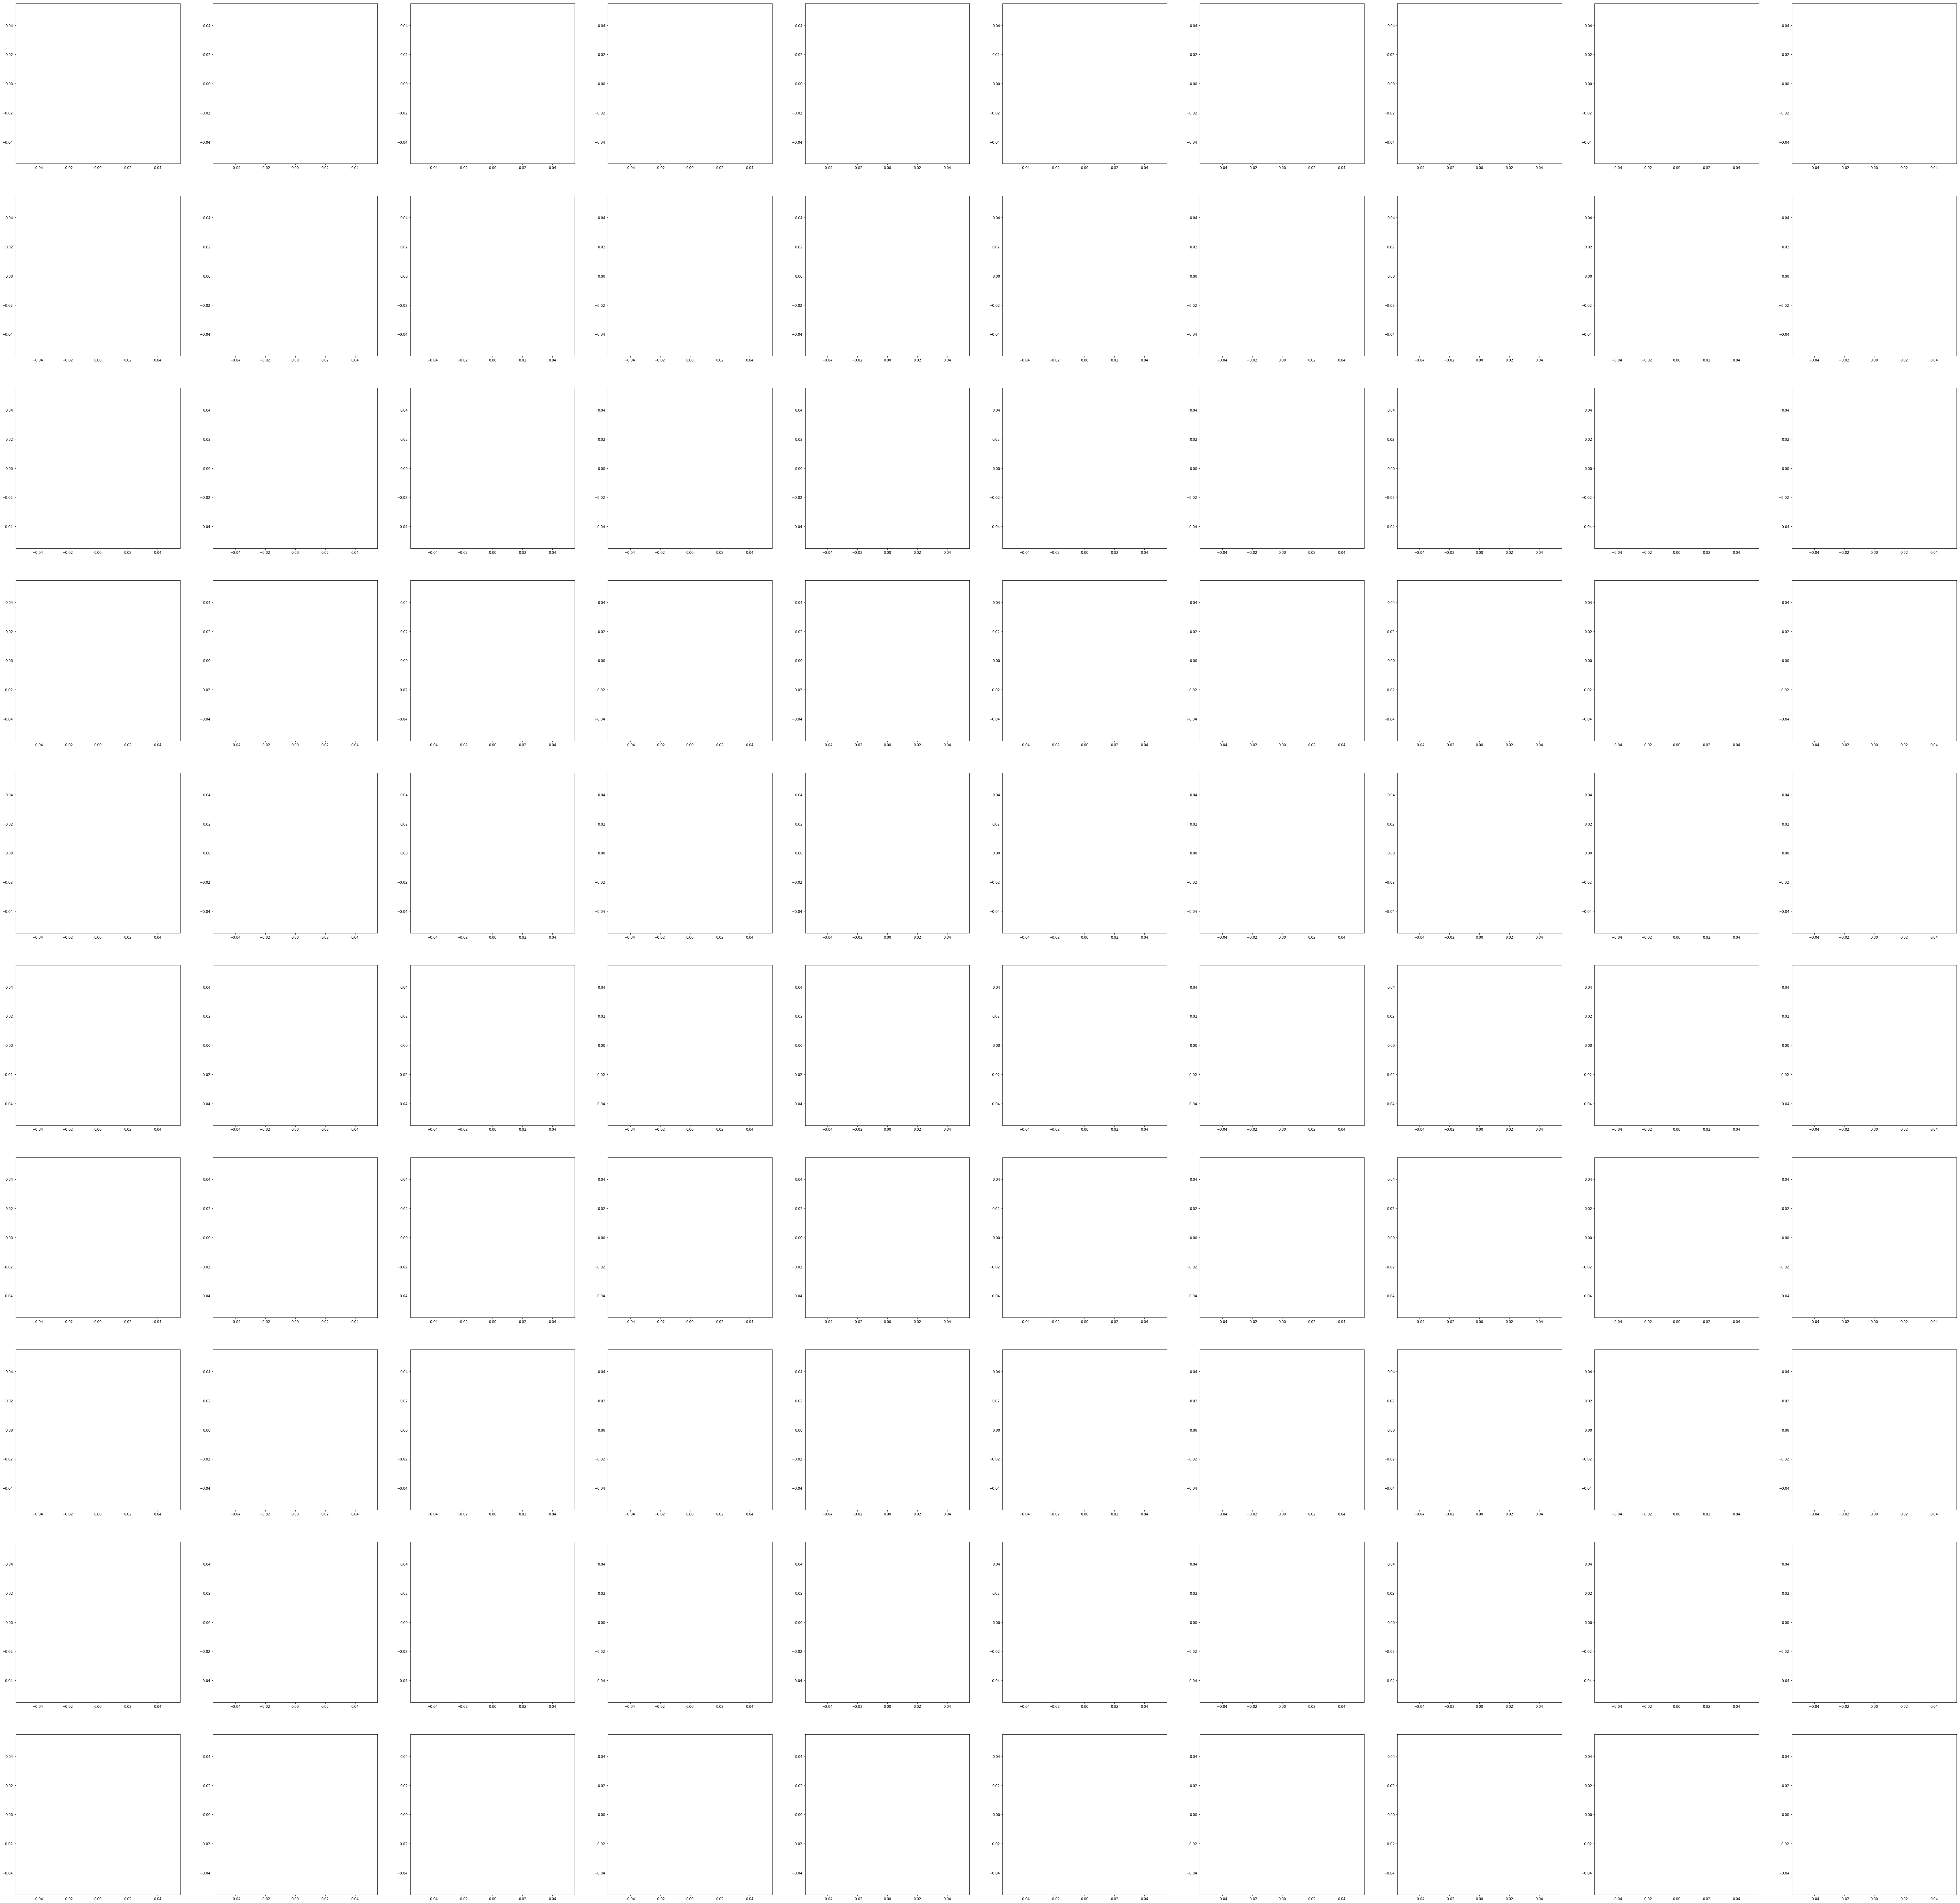

In [17]:
VAE_builder(latent_dim=2, filters=16, epochs=30, batch_size=128, kernel_size=3, input_shape =(212,212,1), plot_res=True)

In [18]:
#plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

    """
    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    
    n = 30
    digit_size = 212
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
                   

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()
    """
    n = 2
    digit_size = 44944
    #figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]
     
    #print(figure.shape)
    z_sample = np.array([[3.7, 3.7]])
    x_decoded = decoder.predict(z_sample)
    print(x_decoded.shape)
    digit = x_decoded[0]
    #print(digit[0,0:200])
    #plt.plot(x_test[0,:])
    print(digit.shape)
    temp = np.reshape(x_decoded, (1, 44944))
    #plt.plot(temp)
    plt.plot(np.reshape(digit, (1, 44944)))
    """       
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            
            print(i, yi)
            print(j,xi)
            
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            print(x_decoded.shape)
            digit = x_decoded[0].reshape(1, 44944)
            plt.plot(digit)
            #figure[i * 1: (i + 1) * 1,
            #       j * 1: (j + 1) * digit_size] = digit
           
        
        plt.figure(figsize=(10, 10))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range + 1
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap='Greys_r')
        plt.savefig(filename)
        plt.show()
        """
    
    

(1, 212, 212, 1)
(212, 212, 1)


'       \n            for i, yi in enumerate(grid_y):\n                for j, xi in enumerate(grid_x):\n            \n                    print(i, yi)\n                    print(j,xi)\n            \n                    z_sample = np.array([[xi, yi]])\n                    x_decoded = decoder.predict(z_sample)\n                    print(x_decoded.shape)\n                    digit = x_decoded[0].reshape(1, 44944)\n                    plt.plot(digit)\n                    #figure[i * 1: (i + 1) * 1,\n                    #       j * 1: (j + 1) * digit_size] = digit\n           \n        \n                plt.figure(figsize=(10, 10))\n                start_range = digit_size // 2\n                end_range = n * digit_size + start_range + 1\n                pixel_range = np.arange(start_range, end_range, digit_size)\n                sample_range_x = np.round(grid_x, 1)\n                sample_range_y = np.round(grid_y, 1)\n                plt.xticks(pixel_range, sample_range_x)\n             

NameError: name 'data' is not defined

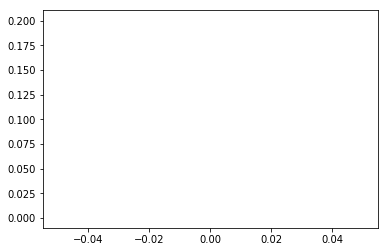

In [19]:
#plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")
model_name="vae_cnn"

#temp = np.reshape(x_train, (x_train.shape[0], 44944))
#plt.plot(temp[6,:])
encoder, decoder = models
x_test, y_test = data
os.makedirs(model_name, exist_ok=True)

filename = os.path.join(model_name, "vae_mean.png")
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)
"""
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig(filename)
plt.show()

filename = os.path.join(model_name, "digits_over_latent.png")
# display a 30x30 2D manifold of digits

n = 30
digit_size = 212
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)

        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit


plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='Greys_r')
plt.savefig(filename)
plt.show()
"""
n = 10
digit_size = 44944
#figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]
fig = plt.figure(figsize=(100, 100))

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        #print(x_decoded.shape)
        digit = x_decoded[0]
        #print(digit[0,0:200])
        #plt.plot(x_test[0,:])
        #print(digit.shape)
        temp = np.reshape(x_decoded, (44944, 1))
        #plt.plot(temp)
        plt.subplot(n,n, i*n + j+1)
        plt.plot(np.reshape(digit, (44944,1)))

plt.show()